# Initializations

In [1]:
import numpy as np
import pandas as pd

import json
from pprint import pprint

import sys, os, time
import glob

from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils
import torch.optim as optim

In [2]:
sys.path.append("/home/nbserver/BEGAN-pytorch/")
import models, utils, models_dcgan
from datafolder import basic_preprocess, default_loader, flip_ndimage

In [3]:
dataroot = "/home/data/world-cities/"

# Load experiment information

In [4]:
experiment_dir = "/home//workspace/citygan/dcgan-0-res64-ngf128-ndf32-nz100/"
# experiment_dir = "/home//workspace/citygan/dcgan-012-datafolder-niter100/"
# experiment_dir = "/home//workspace/citygan/dcgan-012-res256-ngf128-ndf32-dropoutGD-afterBN/"

with open(experiment_dir + "/params.json") as f:    
    config = json.load(f)
    
# Load last checkpointed generator model

# files_cptG = glob.glob(experiment_dir + "G*.pth")
files_cptG = glob.glob(experiment_dir + "*G*.pth")
files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}
netG_ckpt = files_cptG[np.max(files_cptG.keys())]
netD_ckpt = netG_ckpt.replace("netG", "netD")
print netG_ckpt
print netD_ckpt

config

/home//workspace/citygan/dcgan-0-res64-ngf128-ndf32-nz100/netG_epoch_51.pth
/home//workspace/citygan/dcgan-0-res64-ngf128-ndf32-nz100/netD_epoch_51.pth


{u'batchSize': 64,
 u'beta1': 0.5,
 u'cuda': True,
 u'custom_loader': False,
 u'dataroot': u'/home/data/world-cities/spatial-maps/splits/0/',
 u'dataset': u'spatial-maps',
 u'fix_dynamic_range': False,
 u'flips': False,
 u'gpu_ids': [0, 1, 2, 3],
 u'imageSize': 64,
 u'lr': 0.0002,
 u'lr_halve': 100,
 u'manualSeed': 6736,
 u'nc': 1,
 u'ndf': 32,
 u'netD': u'/home/workspace/citygan/dcgan-0-res64-ngf128-ndf32-nz100/netD_epoch_51.pth',
 u'netG': u'/home/workspace/citygan/dcgan-0-res64-ngf128-ndf32-nz100/netG_epoch_51.pth',
 u'ngf': 128,
 u'niter': 100,
 u'normalize': False,
 u'nz': 100,
 u'outf': u'/home/workspace/citygan/dcgan-0-res64-ngf128-ndf32-nz100',
 u'rotate_angle': 0,
 u'take_log': False,
 u'use_channels': None,
 u'workers': 12}

In [5]:
# Load DCGAN model

z_num = config['nz']
width = config['imageSize']
channel_names = ['bldg', 'pop', 'lum']
nc = config['nc']
gpu_ids = [0]# ,1,2,3]
repeat_num = int(np.log2(width)) - 3

netG = models_dcgan.GeneratorCNN(z_num, config['ngf'], config['nc'], 
                                 repeat_num, gpu_ids, dropout=0)
netG.load_state_dict(torch.load(netG_ckpt))

if torch.cuda.is_available() and len(gpu_ids)>0:
    netG = netG.cuda()
    
netG

GeneratorCNN (
  (main): Sequential (
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)

In [6]:
netD = models_dcgan.DiscriminatorCNN(config['ndf'], config['nc'], 
                                     repeat_num, gpu_ids, dropout=0)
netD.load_state_dict(torch.load(netD_ckpt))
netD

DiscriminatorCNN (
  (main): Sequential (
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid ()
  )
)

#### Generate synthetic samples

In [7]:
def generate_samples(netG, Z, cuda=False):
    N, nz = Z.shape[:2]
    Zv = torch.FloatTensor(Z.reshape(N, nz,1,1))
    if cuda:
        Zv = Zv.cuda()
    Zv = Variable(Zv)
    fake = netG(Zv)
    return fake

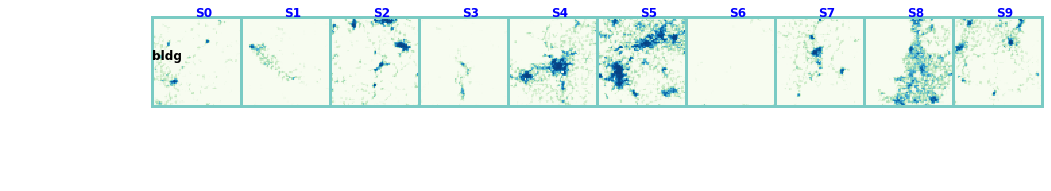

In [8]:
N = 10

Z = np.random.randn(N, z_num)

x_fake = generate_samples(netG, Z.reshape((N,z_num,1,1)), cuda=True)

utils.save_image_channels(x_fake.data, 
                          ncol=x_fake.size()[0], 
                          sample_names=["S%d"%i for i in range(N)],
                          channel_names=["bldg", "pop", "lum"])

##### Compare synthetic samples to real samples

In [9]:
def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    if img.ndim == 3: # rgb or rgba array
        framed_img = np.ones((b+ny+b, b+nx+b, img.shape[2]))
    elif img.ndim == 2: # grayscale image
        framed_img = np.ones((b+ny+b, b+nx+b))
    framed_img[b:-b, b:-b] = img
    return framed_img

def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)

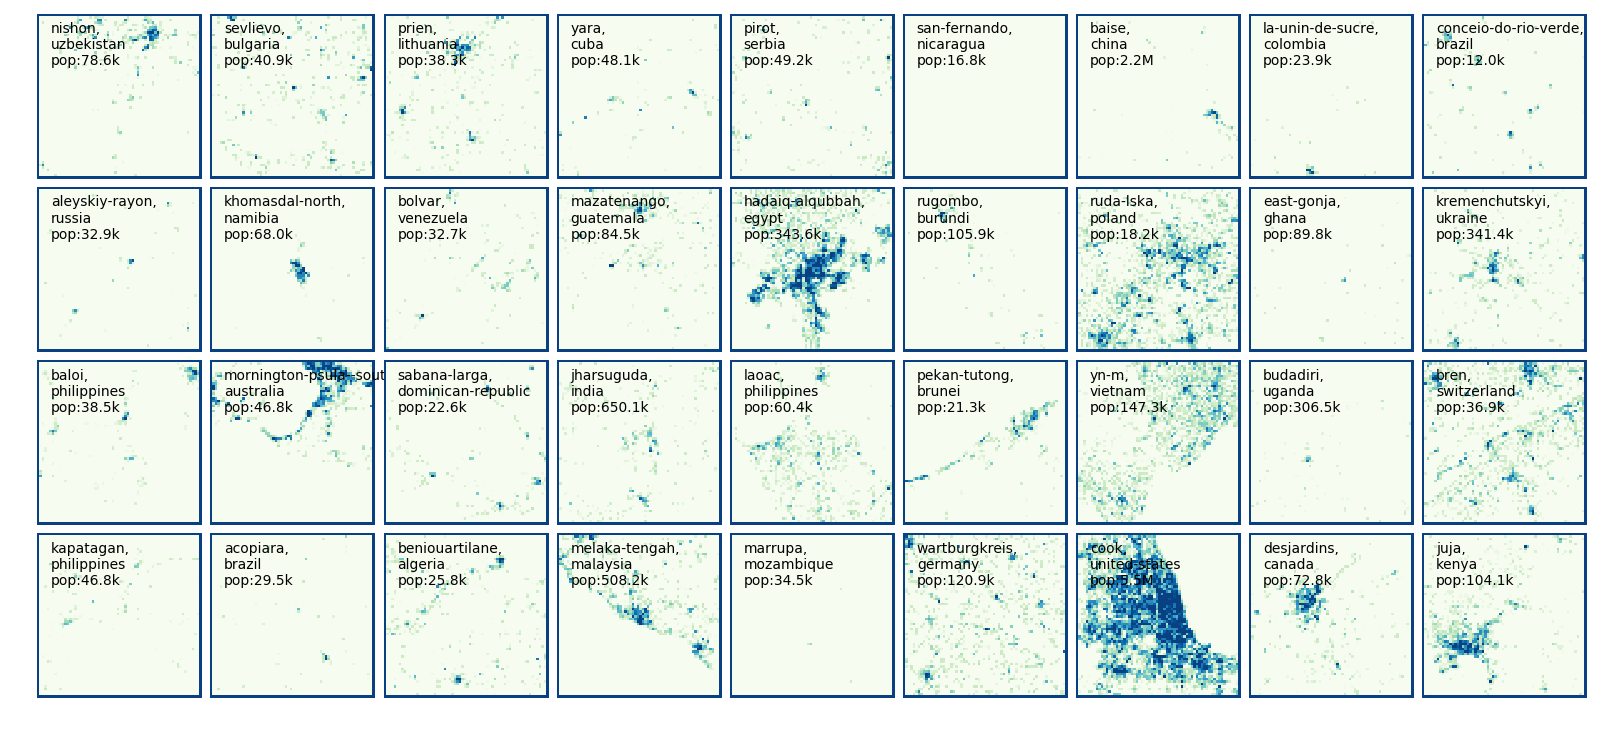

In [212]:
# plot real samples
N = 36
files = np.array(glob.glob(config['dataroot'] + "/*/*.png"))
files = files[np.random.randint(0, len(files), N)]
img_list = [resize(imread(f), (width,width)) for f in files]
img_arr = np.expand_dims(np.dstack(img_list).transpose((2,0,1)), 1)
img_arr = img_arr.reshape((N*nc,1,width,width), order='C')
img_arr.shape

# # generate grid of images using the make_grid utility in torchvision
# grid = vutils.make_grid(torch.from_numpy(img_arr), nrow=9, padding=1,
#                         normalize=True, scale_each=True).numpy()

sns.reset_defaults()
fig, ax = plt.subplots(nrows=4, ncols=N/4, figsize=(20,9), 
                       gridspec_kw={"wspace":0.05, "hspace":0.0})
for img, f, a in zip(img_list, files, ax.flatten()):
    country, province, city, cityclass, pop = os.path.basename(f).split("_")[:-2]
    a.imshow(frame_image(img,1), cmap=cm.GnBu)
    title = "%s,\n%s\npop:%s" % (city, country,format_pop(int(pop)))
    a.annotate(title, xy=(5,20))
    _ = a.axis("off")
    
fig.savefig('../figures/example_real_cities.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')


In [213]:
fig.savefig('../figures/example_real_cities.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')


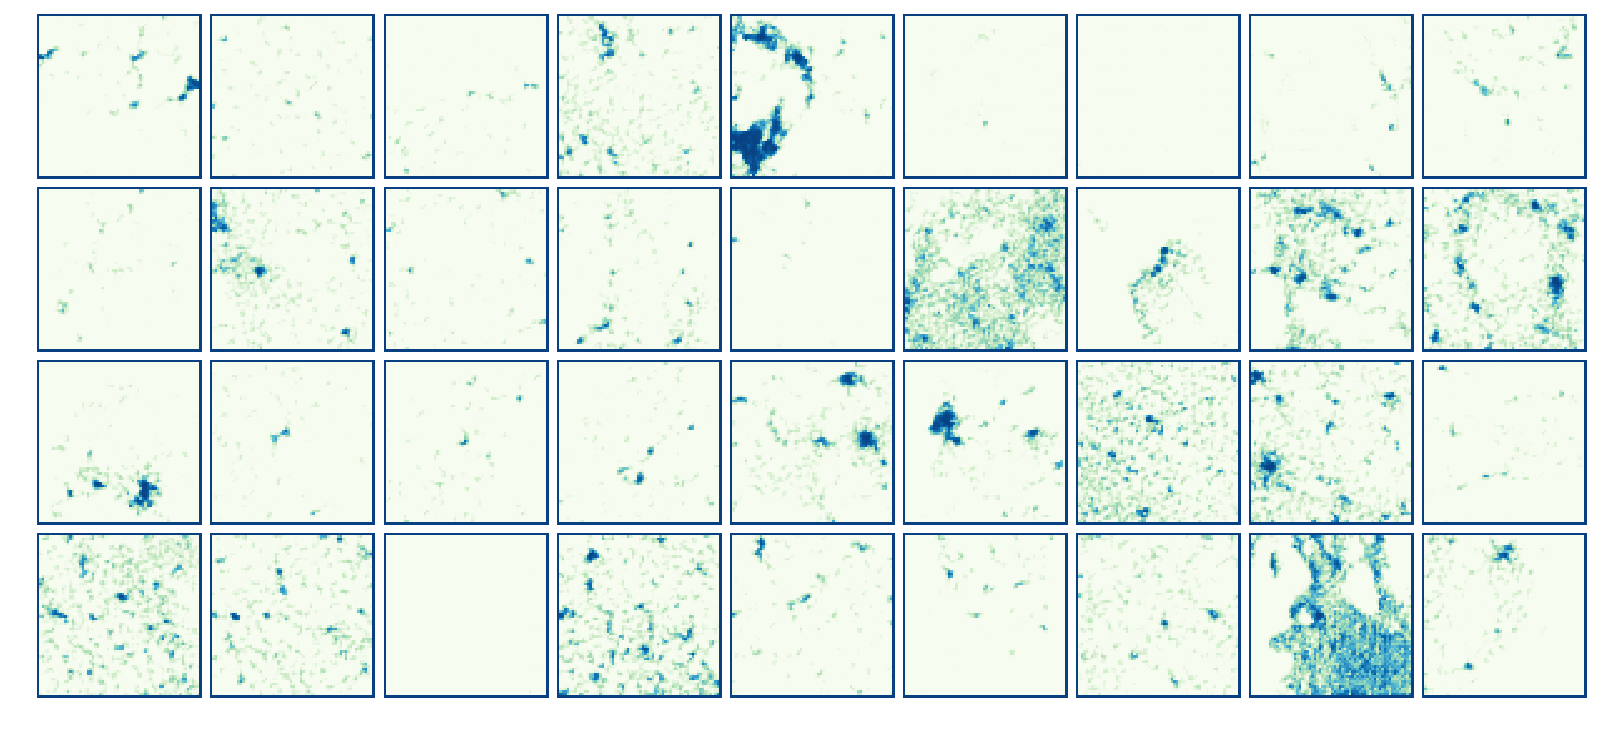

In [214]:
# plot fake examples

N = 36

Z = np.random.randn(N, z_num)
img_fake = generate_samples(netG, Z.reshape((N,z_num,1,1)), cuda=True)\
            .cpu().data.numpy()

fig, ax = plt.subplots(nrows=4, ncols=N/4, figsize=(20,9), 
                       gridspec_kw={"wspace":0.05, "hspace":0.0})
for i, a in enumerate(ax.flatten()):
    img = img_fake[i][0]
    a.imshow(frame_image(img,1), cmap=cm.GnBu)
    _ = a.axis("off")
    
fig.savefig('../figures/example_fake_cities.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')


# Compare radial average profiles for real vs fake

Generate many synthetic cities, compare stats with those of real cities.

In [12]:
colormap = {"bldg":"black", "pop":"green", "lum":"orange", 
            "all":"blue", "bnds":"gray"}

def get_profiles(city_info):
    prof = {}
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = city_info['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        p = mu / scale
        p[np.isnan(p)] = 0
        prof[s] = p
    return prof

def plot_profiles(city_info, a, title=None):
    prof = get_profiles(city_info)
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        a.plot(distance_km[2:], prof[s], lw=3, label=s, color=colormap[s])
     # a.legend(loc="best")
    if title is not None:
        a.set_title(title)
        

##### Load stats for real cities

In [13]:
# load pre-computed profile data
import gzip 
import cPickle as pickle
from shapely.geometry import shape
from shapely.wkt import loads

with gzip.open(dataroot + "spatial-maps/stats_cities_over10kpop.pickle.gz", "r") as f:
    cities = pickle.load(f)
print len(cities)  

info_df = pd.DataFrame(np.array(
                        [[v['city'] for k,v in cities.iteritems()],
                         [v['country'] for k,v in cities.iteritems()],
                         [int(float(v['population'])) for k,v in cities.iteritems()],
                         [v['size'] for k,v in cities.iteritems()],
                         [v['subregion'] for k,v in cities.iteritems()],
                         [v['region'] for k,v in cities.iteritems()]]).T,
                      columns=['city', "country", "population", 'scale-pop', 'subregion', 'region'])
info_df['population'] = info_df['population'].astype(int)

L = len(cities.values()[0]['profiles']['bldg'][0]) # length of profile in km
distance_km = np.arange(L)

# extract profile data

Xbld = np.vstack([v['profiles']['bldg'][0] for k,v in cities.iteritems()])
Xbld[np.isnan(Xbld)] = 0

# normalize profiles by the scale

Xbld_hat = Xbld / Xbld.max(1)[:,None]
Xbld_hat[np.isnan(Xbld_hat)] = 0

# convert to logarithmic space

Xbld_hat_log = np.log10(Xbld_hat)
Xbld_hat_log[np.isnan(Xbld_hat_log)] = 0
Xbld_hat_log[np.isneginf(Xbld_hat_log) | np.isinf(Xbld_hat_log)] = 0

29850


##### Generate many synthetic cities, compute radial profiles

In [16]:
import sys
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis")
from cityanalysis import City
from cityanalysis import fractal_dimension

def compute_profiles(img0, mask, bnds, sample_name, step=1.0):
    img = img0.copy()
    city = City(img, mask=mask, bounds=bnds, name=sample_name, 
                sources=["bldg"])
    try:
        city.analyze(step=step)
        city.analyze(step=step, within_bounds=True)
    except:
        return None
    stats = {"profiles":{k:(np.nan_to_num(v[0]), np.nan_to_num(v[1]))\
                         for k,v in city.profiles.iteritems()}, 
             "profiles bnds":{k:(np.nan_to_num(v[0]), np.nan_to_num(v[1]))\
                         for k,v in city.profiles_bnds.iteritems()}, 
             "frac dim":city.fractal_dim, 
             "frac dim bnds":city.fractal_dim_bnds, 
             "avg area":city.avg_areas, 
             "sum area":city.sum_areas, 
             "avg area bnds":city.avg_areas_bnds, 
             "sum area bnds":city.sum_areas_bnds, 
             "area dis":city.areas_distr,
             "area dis bnds":city.areas_distr_bnds,
            }
    return stats


In [203]:
N = 100000
n = 100

cities_fake = []
mask = np.ones((width, width))
bnds = np.ones((width, width))
for b in np.arange(0, N/n):
    clear_output(wait=True)
    print b, "/", N/n
    # generate fake cities batch
    Z = np.random.randn(n, z_num)
    x_fake = generate_samples(netG, Z.reshape((n,z_num,1,1)), cuda=True)
    img_fake = x_fake.data.cpu().numpy().transpose((0,2,3,1))
    # compute stats
    for i in range(n):
        img = img_fake[i]
        img = basic_preprocess(img, width, normalize=True)
        s = compute_profiles(img, mask, bnds, "", step=0.67)
        cities_fake += [s]       
    

999 / 1000


In [204]:
Xbld_fake = np.vstack([v['profiles']['bldg'][0] for v in cities_fake])
Xbld_fake[np.isnan(Xbld_fake)] = 0

Xbld_fake_hat = Xbld_fake / Xbld_fake.max(1)[:,None]
Xbld[np.isnan(Xbld)] = 0

# normalize profiles by the scale

Xbld_hat_fake = Xbld_fake / Xbld_fake.max(1)[:,None]
Xbld_hat_fake[np.isnan(Xbld_hat_fake)] = 0

# convert to logarithmic space

Xbld_hat_fake_log = np.log10(Xbld_hat_fake)
Xbld_hat_fake_log[np.isnan(Xbld_hat_fake_log)] = 0
Xbld_hat_fake_log[np.isneginf(Xbld_hat_fake_log) | np.isinf(Xbld_hat_fake_log)] = 0

# Compare avg. radial gradient: real vs fake

In [78]:
from scipy.stats import linregress

def f_ols(y):
    g, c, R, p, s = linregress(distance_km,y)
    return g, c, R**2, p, s

def ecdf(arr):
    hist, bins = np.histogram(arr,bins=100)
    hist = hist / float(len(arr))
    return bins[:-1], np.cumsum(hist)

In [205]:
# average radial gradient: real cities

grad_bld = map(f_ols, Xbld_hat_log)
grad_bld = pd.DataFrame(grad_bld, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_bld = pd.concat([info_df, grad_bld], axis=1)
grad_bld['slope'][grad_bld['pvalue']>0.05] = 0

# average radial gradient: fake cities

grad_bld_fake = map(f_ols, Xbld_hat_fake_log)
grad_bld_fake = pd.DataFrame(grad_bld_fake, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_bld_fake['slope'][grad_bld_fake['pvalue']>0.05] = 0

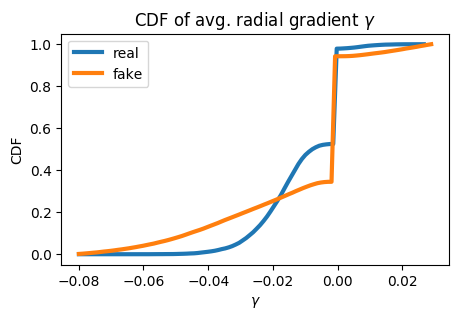

In [215]:
p = -0.08
q = 0.03

gamma_real = grad_bld['slope'][(grad_bld['slope']>p) & (grad_bld['slope']<q)]
bins_real, gamma_cdf_real = ecdf(gamma_real)

gamma_fake = grad_bld_fake['slope'][(grad_bld_fake['slope']>p) & (grad_bld_fake['slope']<q)]
bins_fake, gamma_cdf_fake = ecdf(gamma_fake)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(bins_real, gamma_cdf_real, label="real", lw=3)
ax.plot(bins_fake, gamma_cdf_fake, label="fake", lw=3)
ax.legend(loc="best")
ax.set_title("CDF of avg. radial gradient $\gamma$")
ax.set_xlabel("$\gamma$")
ax.set_ylabel("CDF")

fig.savefig('../figures/CDF_gamma_real_vs_fake.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')


# Compare # peaks for real vs fake

In [192]:
import peakutils

def find_peaks(x, theta=0.15, xi=4):
    if x.sum()>0:
        idx = peakutils.indexes(x, thres=theta, min_dist=xi)
        return idx
    else:
        return []

def find_nr_peaks(X, theta=0.15, xi=4):
    idx_peaks = map(lambda x: find_peaks(x, theta=theta, xi=xi),X)
    return map(lambda x: len(x), idx_peaks)    

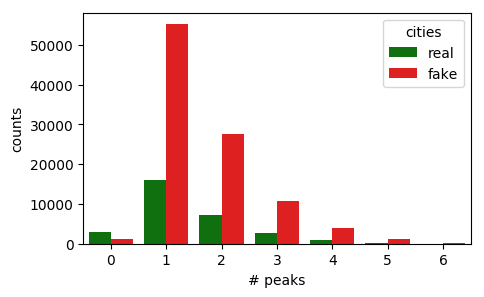

In [216]:
peaks_bld_real = find_nr_peaks(Xbld_hat, theta=0.6, xi=6)
peaks_bld_fake = find_nr_peaks(Xbld_hat_fake, theta=0.6, xi=6)

peaks_df = pd.DataFrame(peaks_bld_real + peaks_bld_fake, columns=["peaks"])
peaks_df['cities'] = 'fake'
peaks_df['cities'][:len(peaks_bld_real)] = 'real'

# peak_data = peaks_df[(peaks_df['peaks']>0) & (peaks_df['peaks']<9)]
peak_data = peaks_df

fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(ax=ax, data=peak_data, 
              x="peaks", hue="cities", palette=["green", "red"])
ax.set_xlabel("# peaks")
ax.set_ylabel("counts")
fig.savefig('../figures/peaks_real_vs_fake.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')

# Compare radial profile clusters real vs fake

##### Extract profile clusters

In [217]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample
from scipy.spatial.distance import cdist, pdist

def kmeans_var_expl(data, n):
    kMeansVar = [MiniBatchKMeans(n_clusters=k, batch_size=1000).fit(data) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(data, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss - wcss
    return tss, bss, wcss

In [ ]:
X_real = Xbld_hat
X_fake = Xbld_hat_fake

# real cities
tss, bss, wcss = kmeans_var_expl(X_real, 50)
var_expl = bss/tss

# fake cities
tss_fake, bss_fake, wcss_fake = kmeans_var_expl(X_fake, 50)
var_expl_fake = bss_fake/tss_fake

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(np.diff(var_expl), lw=3, label="real", color="green")
plt.plot(np.diff(var_expl_fake), lw=3, label="synth.", 
         color="red", linestyle="--")
plt.axvline(x=10, color='black')
plt.title("Optimum # clusters $K^*$ \n(real vs synthetic)")
plt.xlabel("# clusters K")
plt.ylabel("pct. var. expl.\n $V_k-V_{k-1}$")
plt.legend(loc="best")
plt.text(12, 0.05, "$|V_k-V_{k-1}|<10^{-3}$")

plt.savefig('../figures/nr_clusters_real_fake.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')


In [ ]:
K_star = 12
mod_real = KMeans(n_clusters=K_star, n_init=10)
mod_real.fit(X_real)
centroids_real = mod_real.cluster_centers_
C_real = mod_real.predict(X_real)

In [ ]:
K_star = 12
mod_fake = KMeans(n_clusters=K_star, n_init=10)
mod_fake.fit(X_fake)
centroids_fake = mod_fake.cluster_centers_
C_fake = mod_fake.predict(X_fake)

In [ ]:
# Find closest cluster correspondents real <--> fake

from scipy.spatial.distance import cdist

D_fake_real = cdist(centroids_fake, centroids_real)

idx_fake2real = D_fake_real.argmin(0)

centroids_fake = centroids_fake[idx_fake2real]

In [ ]:
def plot_clusters(X, C, centroids, 
                  nrow=1, text="", figsize=(6,4), top=0.75,
                  xlabels=True):
    K = len(np.unique(C))
    clust_sizes = pd.Series(C).value_counts().values
    nx = nrow
    ny = K / nx
    fig, ax = plt.subplots(nx,ny, 
                           gridspec_kw={"wspace":0.15, "hspace":0.3},
                           figsize=figsize, sharex=True, sharey=True)
    if len(ax.shape)==1:
        ax = np.expand_dims(ax, axis=0)
    for k,a in zip(range(K), ax.flatten()):
        idx = np.where(C == k)[0]
        std = X[idx,:].std(0)
        a.fill_between(distance_km,
           centroids[k,:]-std, 
           centroids[k,:]+std, 
           color=colormap[text], alpha=0.3)
        a.plot(distance_km, centroids[k,:], lw=5, color=colormap[text])
        # a.axis("off")
        a.set_title("C%d: %2.1f%%"%(k,100*float(clust_sizes[k])/clust_sizes.sum()))
        if k / ny == nx-1:
            if xlabels: a.set_xlabel("d [km]")
            a.set_xticks(distance_km[::6])
            a.set_xticklabels(distance_km[::6], rotation=30)
        if k % ny == 0:
            a.set_ylabel("$x_{\cdot}(d)$")

    plt.suptitle("Classes of normalized profiles $x_{\cdot}(d)$: centroids")
    fig.subplots_adjust(top=top)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(X_real, C_real, centroids_real, text="all", 
              nrow=3, figsize=(14,7), top=0.88, xlabels=False)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(X_fake, C_fake, centroids_fake, text="all", 
              nrow=3, figsize=(14,7), top=0.88, xlabels=False)

In [ ]:
centroids_fake